# Refactored workflow example

This notebook runs the same history matching workflow as in the integration tutorial but uses the refactored history matcher that is currently in experimental as well as the GP emulator in experimental.

In [1]:
import os
import gpytorch
import torch
import pandas as pd

# imports from main
from autoemulate.emulators.gaussian_process import constant_mean, rbf
from autoemulate.experimental_design import LatinHypercube
from autoemulate.history_matching_dashboard import HistoryMatchingDashboard
from autoemulate.simulations.naghavi_cardiac_ModularCirc import NaghaviSimulator, extract_parameter_ranges

# imports from experimental
from autoemulate.experimental.emulators.gaussian_process.exact import (
    GaussianProcessExact,
)
from autoemulate.experimental.history_matching import HistoryMatching

/Users/rjersakova/Documents/Projects/autoemulate/autoemulate/history_matching_dashboard.py:953: SyntaxWarning: invalid escape sequence '\m'
  return f"$\mu_{{{base_name}}}$"


## Simulate

Set up the Simulator and generate data OR read a data file if have run this previously.

In [2]:
parameters_range = extract_parameter_ranges(
    '../../../docs/data/naghavi_model_parameters.json'
)

simulator = NaghaviSimulator(
    parameters_range=parameters_range, 
    output_variables=['lv.P_i', 'lv.P_o'],  # Only the ones you're interested in
    n_cycles=300, 
    dt=0.001,
)

In [3]:
inputs_path = 'parameters.csv'
results_path = 'simulator_results.csv'

# Check if the results file already exists
if not os.path.exists(results_path):
    N_samples = 100
    lhd = LatinHypercube(list(parameters_range.values()))
    sample_array = lhd.sample(N_samples)
    sample_df = pd.DataFrame(sample_array, columns=parameters_range.keys())
    
    # Run batch simulations with the samples generated in Cell 1
    results = simulator.run_batch_simulations(sample_df)
    # Convert results to DataFrame for analysis
    results_df = pd.DataFrame(results)
    # Save the results to a CSV file
    results_df.to_csv(results_path, index=False)
    sample_df.to_csv(inputs_path, index=False)
else:
    results_df = pd.read_csv(results_path)
    sample_df = pd.read_csv(inputs_path)
    # have to run simulator once to populate simulator.output_names
    _ = simulator.sample_forward(sample_df.iloc[0])

y = torch.from_numpy(results_df.to_numpy()).float()
x = torch.from_numpy(sample_df.to_numpy()).float()

## Train a GP

(this should be done with AutoEmulate obviously)

In [4]:
gp = GaussianProcessExact(
        x,
        y,
        gpytorch.likelihoods.MultitaskGaussianLikelihood,
        constant_mean,
        rbf,
    )

In [5]:
gp.fit(x, y)

## History Matching

In [6]:
# Define observed data with means and variances
observations = {
    'lv.P_i_min': (5.0, 0.1),   # Minimum of minimum LV pressure
    'lv.P_i_max': (20.0, 0.1),   # Maximum of minimum LV pressure
    'lv.P_i_mean': (10.0, 0.1),  # Mean of minimum LV pressure
    'lv.P_i_range': (15.0, 0.5), # Range of minimum LV pressure
    'lv.P_o_min': (1.0, 0.1),  # Minimum of maximum LV pressure
    'lv.P_o_max': (13.0, 0.1),  # Maximum of maximum LV pressure
    'lv.P_o_mean': (12.0, 0.1), # Mean of maximum LV pressure
    'lv.P_o_range': (20.0, 0.5)  # Range of maximum LV pressure
}

# Create history matcher
hm = HistoryMatching(
    simulator=simulator,
    observations=observations,
    threshold=3.0
)

History Matching involves:
- sampling parameters
- making predictions for those parameterings
- evaluating implausability of predictions
- identifying which of the paraneters are not ruled out yet (NROY)

In [7]:
x = hm.sample_params(5)
pred_means, pred_vars, _ = hm.predict(x, emulator=gp)
implausability = hm.calculate_implausibility(pred_means, pred_vars)
nroy_indices = hm.get_nroy(implausability)

implausability, nroy_indices

(tensor([[0.5718, 6.1953, 1.6543, 4.7003, 2.3911, 3.0088, 2.5649, 7.1212],
         [0.5718, 6.1953, 1.6543, 4.7003, 2.3911, 3.0088, 2.5649, 7.1212],
         [0.5718, 6.1953, 1.6543, 4.7003, 2.3911, 3.0088, 2.5649, 7.1212],
         [0.5718, 6.1953, 1.6543, 4.7003, 2.3911, 3.0088, 2.5649, 7.1212],
         [0.5718, 6.1953, 1.6543, 4.7003, 2.3911, 3.0088, 2.5649, 7.1212]]),
 tensor([], dtype=torch.int64))

We can execture an iterative sample-predict-evaluate procedure with `HM.run()`.

In [9]:
emulator = hm.run(
    n_waves=20,
    n_samples_per_wave=20,
    emulator_predict=True,
    emulator=gp,
)

History Matching: 100%|██████████| 20/20 [00:00<00:00, 38.32wave/s, samples=20, failed=0, NROY=0, min_impl=0.57, max_impl=7.12]


In [10]:
hm.tested_params.shape, hm.impl_scores.shape

(torch.Size([400, 16]), torch.Size([400, 8]))

In [11]:
dashboard = HistoryMatchingDashboard(
    samples=hm.tested_params,
    impl_scores=hm.impl_scores,
    param_names=simulator.param_names,  
    output_names=simulator.output_names, 
    )

HTML(value='<h2>History Matching Dashboard</h2>')

HTML(value='\n            <div style="background-color: #f8f9fa; padding: 15px; border-radius: 5px; margin-bot…

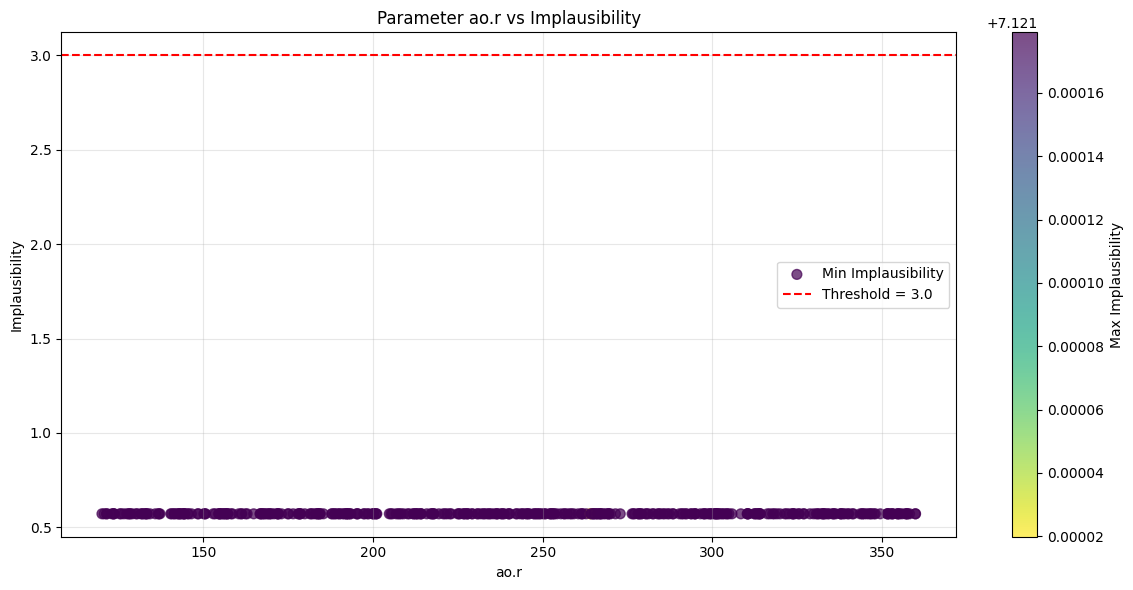

In [12]:
dashboard.display()